In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import math

import warnings
warnings.filterwarnings("ignore")

daily_train = pd.read_csv('..\Dataset\Quarterly-train.csv')
daily_test = pd.read_csv('..\Dataset\Quarterly-test.csv')

__Selecting the Time Series Data for Our Predictions__

In [2]:
df = daily_train.transpose() # The data we train the model
test = daily_test.transpose() # The last actual values which we try to predict

df = df[25]
df = df.iloc[1:]
df = df.dropna()
new_index = pd.RangeIndex(start=0, stop=len(df))
df.index = new_index

test = test[25]
test = test.iloc[1:]
df = df.reset_index(drop=True)
test = test.reset_index(drop=True)
new_index = pd.RangeIndex(start=len(df), stop=len(df) + len(test))
test.index = new_index

# Connect all dataset train(df) and test data
Series = pd.concat([df, test], axis=0)
Series1 = pd.concat([df, test], axis=1, keys=['Train', 'Test'])

In [3]:
Series1 = Series1.apply(pd.to_numeric, errors='coerce')
Series1.describe()

,Train,Test
count,59.000000,8.000000
mean,7555.254237,8275.000000
std,977.515069,1021.651324
min,4810.000000,7040.000000
25%,6905.000000,7662.500000
50%,7490.000000,7910.000000
75%,8225.000000,9077.500000
max,9930.000000,9900.000000


<AxesSubplot:title={'center':'Train and Test Data'}, xlabel='Time', ylabel='Price'>

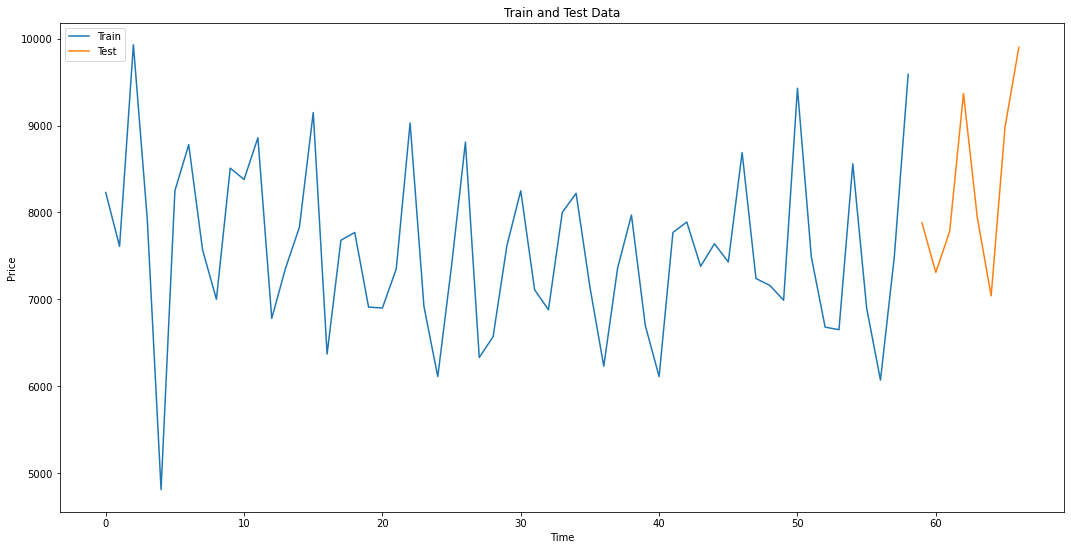

In [4]:
Series1.plot(figsize=(18,9),title='Train and Test Data',xlabel='Time',ylabel='Price')

In [5]:
print('The size of our data is ',len(df))
print('The size of the predicted data is ',len(test))

The size of our data is  59
The size of the predicted data is  8


__Time Series Decomposition: Visualizing Trend, Seasonal, and Residual Components__

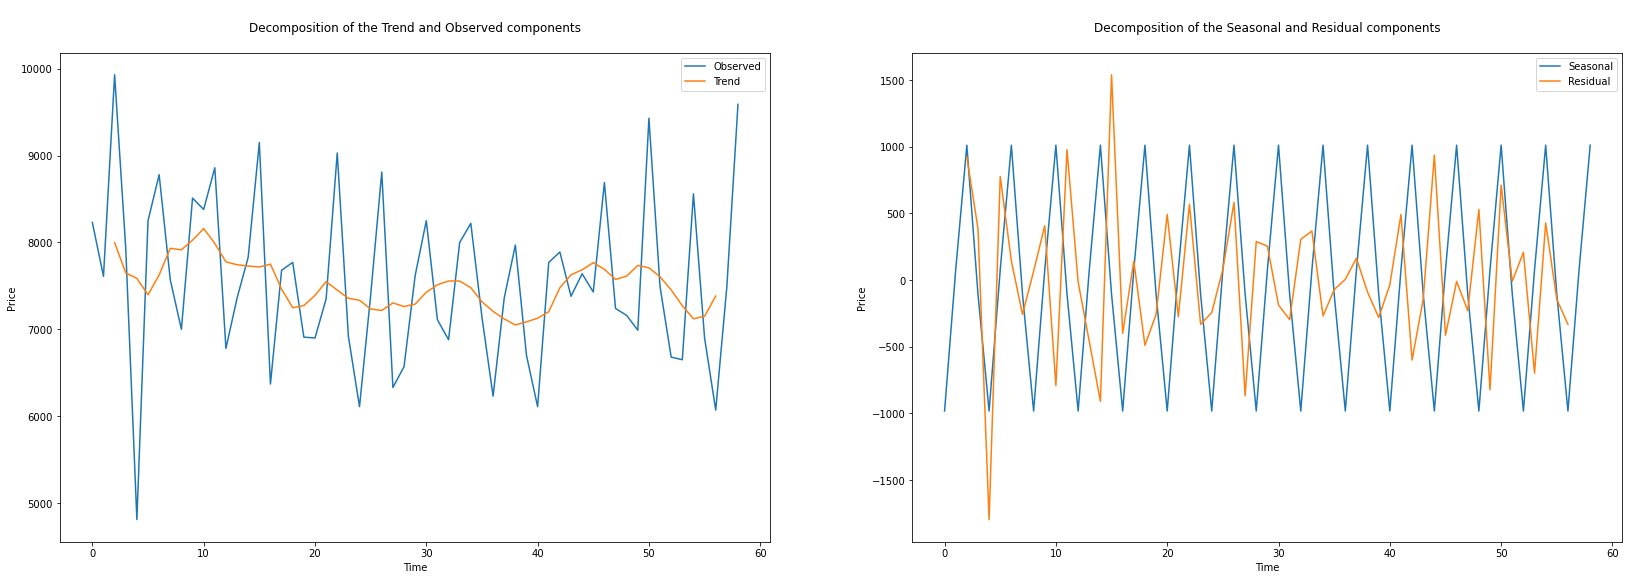

In [6]:
decomp = seasonal_decompose(df, model='additive', period=4)
observed = decomp.observed
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid
data = pd.concat([observed, trend, seasonal, residual], axis=1)
data.columns = ['observed', 'trend', 'seasonal', 'residual']

fig, axes = plt.subplots(1, 2, figsize=(28, 9))
observed.plot(ax=axes[0], label='Observed')
trend.plot(ax=axes[0], label='Trend')
axes[0].set_title('\nDecomposition of the Trend and Observed components\n')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price')
axes[0].legend()


seasonal.plot(ax=axes[1], label='Seasonal')
residual.plot(ax=axes[1], label='Residual')
axes[1].set_title('\nDecomposition of the Seasonal and Residual components\n')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price')
axes[1].legend()
plt.show()

**Holt-Winter's Multiplicative Seasonality and Trend using the library ExponentialSmoothing**

Estimated alpha: 0.11107142857142857
Estimated beta: 0.11107142857142857
Estimated gamma: 0.19753968253968254 

Metrics to evaluate the model for the Forecasting
MAE - manual: 783.4778644491888
MAPE - manual: 0.0919535720652941
MSE - manual: 764148.019787075
RMSE - manual: 27.99067459796546



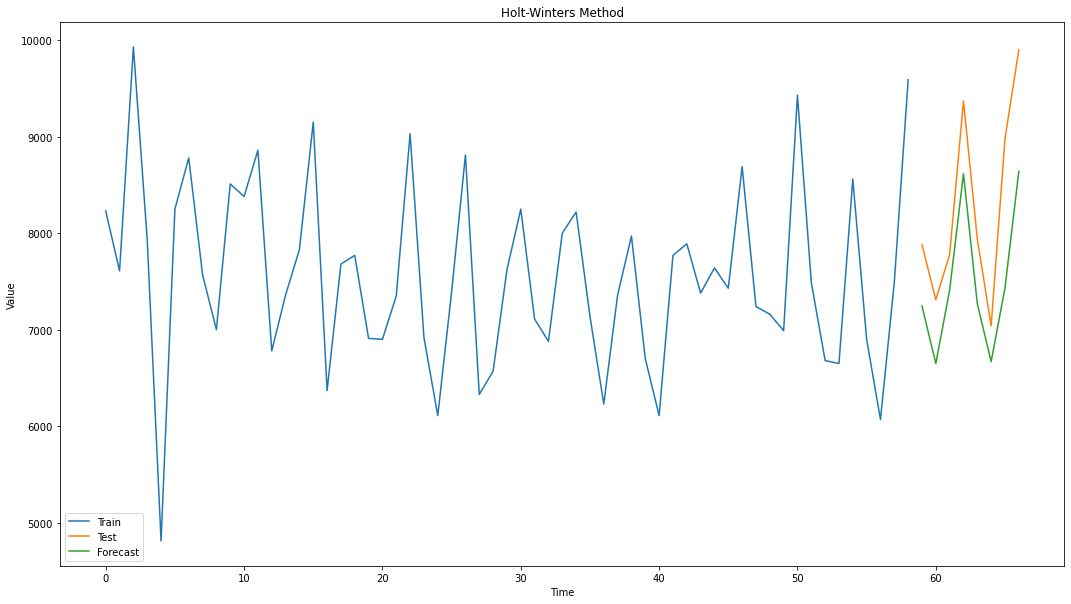

In [7]:
data = np.asarray(df)
model = ExponentialSmoothing(data, seasonal_periods=4, trend='mul', seasonal='mul')
model_fit = model.fit(optimized=True)

forecast = model_fit.predict(start=len(df), end=(len(df) + len(test))-1)

Holt_Winter = pd.DataFrame(forecast)
Holt_Winter = Holt_Winter.rename(columns={0: "Forecasting"})
Holt_Winter.index = pd.RangeIndex(start=len(df), stop=len(df) + len(test))

alpha = model_fit.params['smoothing_level']
beta = model_fit.params['smoothing_trend']
gamma = model_fit.params['smoothing_seasonal']
print("Estimated alpha:", model_fit.params['smoothing_level'])
print("Estimated beta:", model_fit.params['smoothing_trend'])
print("Estimated gamma:", model_fit.params['smoothing_seasonal'],'\n')

mae = mean_absolute_error(test, Holt_Winter[:len(test)])
mape = mean_absolute_percentage_error(test, Holt_Winter[:len(test)])
mse = mean_squared_error(test, Holt_Winter[:len(test)])
rmse = np.sqrt(mean_absolute_error(test, Holt_Winter[:len(test)]))
print(f'Metrics to evaluate the model for the Forecasting')
print(f'MAE - manual: {mae}')
print(f'MAPE - manual: {mape}')
print(f'MSE - manual: {mse}')
print(f'RMSE - manual: {rmse}\n')


plt.figure(figsize=(18, 10))
plt.plot(df.tail(100), label='Train')
plt.plot(test, label='Test')
plt.plot(Holt_Winter.tail(100), label='Forecast')
plt.title('Holt-Winters Method')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

**Holt-Winter's Multiplicative Seasonality and Trend: Triple Exponential Smoothing Implementation**<br><br>

**Mathematical Model**

![](Holt-Winter.jpg)

![](Initial_values_holt-winter.jpg)

## Explanation of the Mathematical Model

This mathematical model, known as the Holt-Winters Triple Exponential Smoothing model, it involves several functions and initialization steps:

### Prediction Function
The prediction function is used to forecast the value at time (t+1). The formula is:

𝑭𝒕+𝟏 = (𝑳𝒕 + 𝑻𝒕 ) * 𝑺𝒕−𝑴

- **𝑭𝒕+𝟏**: Represents the predicted value at time (t+1).
- **𝑳𝒕**: Denotes the current level at time t.
- **𝑻𝒕**: Signifies the current trend at time t.
- **𝑺𝒕−𝑴−𝒉**: Represents the seasonality at time t-M-h.
- **h**: Indicates the number of periods ahead we want to predict.
- **M**: Seasonal period.

### Level Function
The level function is used to estimate the level value at a specific time (t). The formula is:

𝑳𝒕 = α * (𝒀𝒕 / 𝑺𝒕−𝑴) + (1 – α) * (𝑳𝒕−𝟏 + 𝑻𝒕−𝟏)

- **𝒀𝒕**: Represents the actual value of the time series at time t.
- **𝒂**: Is a constant smoothing parameter for the level.
- **𝑳𝒕−𝟏**: Represents the previous level estimation at time t-1.
- **𝑻𝒕−𝟏**: Denotes the previous trend estimation at time t-1.

### Trend Function
The trend function is responsible for estimating the trend value at a specific time (t). The formula is:

𝑻𝒕 = β * (𝑳𝒕 + 𝑳𝒕−𝟏) + (1 – β) * 𝑻𝒕−𝟏

- **β**: Is a constant smoothing parameter for the trend.

### Seasonality Function
The seasonality function estimates the seasonal component at time (t). The formula is:

𝑺𝒕 = γ * (𝒀𝒕 / 𝑳𝒕) + (1 – γ) * 𝑺𝒕−𝑴

- **γ**: Is a constant smoothing parameter for seasonality.

This mathematical model allows us to make predictions for future time points based on the level, trend, and seasonality estimates computed in previous steps. It is particularly effective for time series data with complex patterns.

To use the Holt-Winters model effectively, certain initializations must be performed:

1. **Initial Estimation of Level (L), Trend (T), and Seasonality (S)**:<br>
   Initially, we need to estimate the starting values for the level (L), trend (T), and seasonality (S) at the first time point. The first time point for level and trend depends on the chosen seasonal period (M), while for seasonality, it is typically t=1. In our case, assuming quarterly data, we chose a seasonal period of 4 (M=4). To calculate the initial estimates:
   - __For M = 4 (Quarterly)__:<br>
    __Seasonality__:
      - 𝑺𝟏 = 𝒀𝟏 / 𝒂𝒗𝒆𝒓𝒂𝒈𝒆(𝒀𝟏+𝒀𝟐+𝒀𝟑+𝒀𝟒) ,<br>
      - 𝑺𝟐 = 𝒀𝟐 / 𝒂𝒗𝒆𝒓𝒂𝒈𝒆(𝒀𝟏+𝒀𝟐+𝒀𝟑+𝒀𝟒) ,<br>
      - 𝑺𝟑 = 𝒀𝟑 / 𝒂𝒗𝒆𝒓𝒂𝒈𝒆(𝒀𝟏+𝒀𝟐+𝒀𝟑+𝒀𝟒) ,<br>
      - 𝑺𝟒 = 𝒀𝟒 / 𝒂𝒗𝒆𝒓𝒂𝒈𝒆(𝒀𝟏+𝒀𝟐+𝒀𝟑+𝒀𝟒)<br>

     __Level__: 𝑳𝟓 = 𝒀𝟓 / 𝑺𝟏<br><br>
    __Trend__: 𝜯𝟓 = 𝑳𝟓 - 𝑳𝟒 <br><br>
    __Calculation of Seasonality 𝑺𝟓__:&emsp;𝑺𝟓 = γ *(𝒀𝟓 / 𝑳𝟓) + (1 – γ) * 𝑺𝟏 <br>

2. **Setting Smoothing Parameters (α, β, and γ)**:<br>
   The model defines three smoothing parameters: α for the level, β for the trend, and γ for seasonality. These parameters determine the weight given to level, trend, and seasonality observations in updating estimates for the next time step.

Once we have initialized the model with initial estimates and smoothing parameters, we can proceed to calculate level, trend, and seasonality estimates for future time periods. These estimates are used to forecast future values, capturing the interaction between level, trend, and seasonality in the data.

The Holt-Winters model is a powerful tool for time series forecasting, capable of handling complex patterns in the data.


Metrics to evaluate the model for the Forecasting
MAE - manual: 708.6747565338351
MAPE - manual: 0.08369175268550551
MSE - manual: 640097.4331145101
RMSE - manual: 26.620945823426993



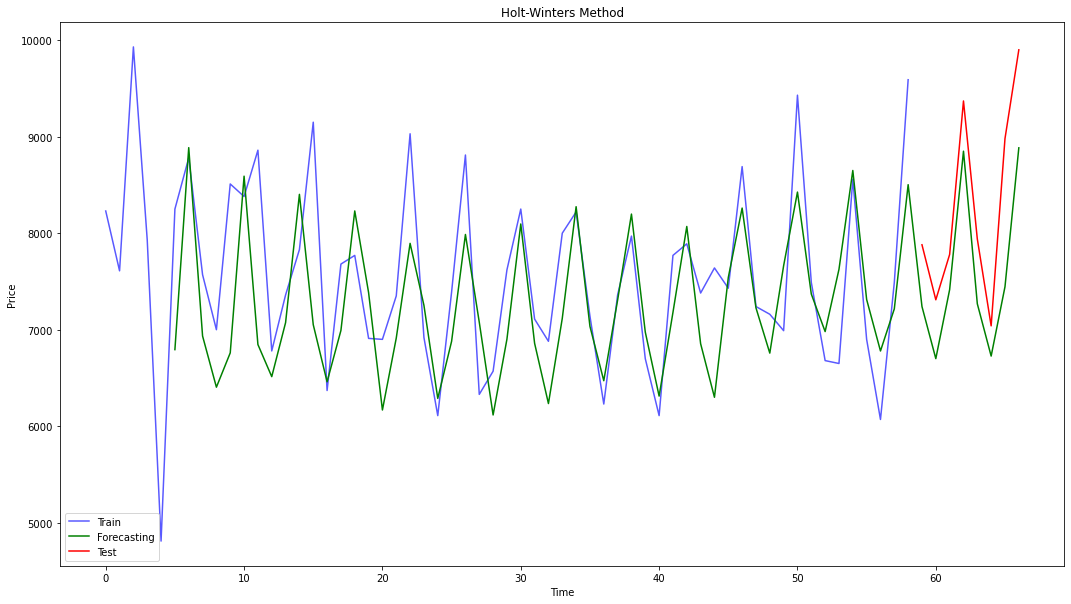

In [8]:
"""
Holt-Winter's Multiplicative Seasonality With Trend

F[t+1] = (L[t] + T[t]) * S[t-M]
    F[t+1]: Forecasted value at time t+1
    L[t]: Level at time t
    T[t]: Trend at time t
    S[t-M-h]: Seasonal component at time t-M-h
    M: Seasonal period length

L[t] = α * (Y[t] / S[t-M]) + (1 - α) * (L[t-1] + T[t - 1])
    L[t]: Level at time t
    Y[t]: Observed value at time t
    S[t-M]: Seasonal component at time t-M
    α: Smoothing parameter for level

T[t] = β * (L[t] - L[t-1]) + (1 - β) * T[t-1]
    T[t]: Trend at time t
    β: Smoothing parameter for trend

S[t] = γ * (Y[t] / L[t]) + (1 - γ) * S[t-M]
    S[t]: Seasonal component at time t
    γ: Smoothing parameter for seasonal component

# https://medium.com/@polanitzer/time-series-methodologies-part-8-holt-winters-multiplicative-seasonality-with-trend-8fda2feb53e5
"""

# Initialize level, trend, seasonal, and forecast lists
level = [0] * (len(df) + len(test))
trend = [0] * (len(df) + len(test))
seasonal = [0] * (len(df) + len(test))
Forecast = [0] * (len(df) + len(test))
M = 4

# Calculate average of the first M values for seasonal component initialization
average = np.mean(df.iloc[0:M].values)

# Calculate seasonal component for the first M values
for i in range(0, M):
    seasonal[i] = df.iloc[i] / average

# Initialize level, trend, and seasonal with the first observed values
level[M-1] = df.iloc[0:M].mean()
level[M] = df.iloc[0:M+1].mean()
trend[M] = (level[M] - level[M-1]) / M
seasonal[M] = gamma * (df.iloc[M] / level[M]) + (1 - gamma) * seasonal[M-1]

# Perform Holt-Winter's Multiplicative Seasonality With Trend
for t in range(M+1, len(df) + len(test)):
    if t < len(df):
        Forecast[t] = (level[t-1] + trend[t-1]) * seasonal[t - M]
        level[t] = alpha * (df.iloc[t] / seasonal[t - M]) + (1 - alpha) * (level[t-1] + trend[t-1])
        trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
        seasonal[t] = gamma * (df.iloc[t] / level[t]) + (1 - gamma) * seasonal[t - M]
    else:
        Forecast[t] = (level[t-1] + trend[t-1]) * seasonal[t - M]
        level[t] = alpha * (Forecast[t] / seasonal[t - M]) + (1 - alpha) * (level[t-1] + trend[t-1])
        trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
        seasonal[t] = gamma * (Forecast[t] / level[t]) + (1 - gamma) * seasonal[t - M]


# Convert Forecast, Level, Trend, and seasonal lists to DataFrames
Forecast = pd.DataFrame(Forecast)
Forecast = Forecast.rename(columns={0: "Forecasting"})
Level = pd.DataFrame(level)
Level = Level.rename(columns={0: 'Level'})
Trend = pd.DataFrame(trend)
Trend = Trend.rename(columns={0: 'Trend'})
seasonal = pd.DataFrame(seasonal)
seasonal = seasonal.rename(columns={0: 'Seasonal'})
# Keep a table with Level, Trend, Seasonal Forecasting and Actual (Series DF) values
table = pd.concat([Level, Trend, seasonal, Forecast, Series], axis=1)
table.rename(columns={25 : 'Actual'}, inplace=True)

# Calculate evaluation metrics
mae = mean_absolute_error(test, Forecast[len(df):len(test)+len(df)+1])
mape = mean_absolute_percentage_error(test, Forecast[len(df):len(test)+len(df)+1])
mse = mean_squared_error(test, Forecast[len(df):len(test)+len(df)+1])
rmse = np.sqrt(mean_absolute_error(test, Forecast[len(df):len(test)+len(df)+1]))
print(f'Metrics to evaluate the model for the Forecasting')
print(f'MAE - manual: {mae}')
print(f'MAPE - manual: {mape}')
print(f'MSE - manual: {mse}')
print(f'RMSE - manual: {rmse}\n')

# Plot the values of the train, test, and forecast data
fig, ax = plt.subplots(figsize=(18, 10))
df.dropna().plot(ax=ax, label='Train', color='blue', legend=True, alpha=0.65)
Forecast[M+1:].dropna().plot(ax=ax, label='Forecast', color='green', legend=True)
test.dropna().plot(ax=ax, label='Test', color='red', legend=True)
plt.title('Holt-Winters Method')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
plt.show()

__Presenting Tables Generated from Mathematical Model Outputs__

In [9]:
table

,Level,Trend,Seasonal,Forecasting,Actual
0,0.000000,0.000000,0.976855,0.000000,8230.0
1,0.000000,0.000000,0.903264,0.000000,7610.0
2,0.000000,0.000000,1.178635,0.000000,9930.0
3,8425.000000,0.000000,0.941246,0.000000,7930.0
4,7702.000000,-180.750000,0.878679,0.000000,4810.0
...,...,...,...,...,...
62,7094.387764,7.021811,1.247389,8849.462283,9370.0
63,7101.409575,7.021811,1.023544,7268.602683,7940.0
64,7108.431385,7.021811,0.946323,6726.869533,7040.0
65,7115.453196,7.021811,1.046343,7445.207121,8980.0


In [10]:
table.tail(len(test))

,Level,Trend,Seasonal,Forecasting,Actual
59,7073.322332,7.021811,1.023544,7239.854164,7880.0
60,7080.344142,7.021811,0.946323,6700.289939,7310.0
61,7087.365953,7.021811,1.046343,7415.818221,7780.0
62,7094.387764,7.021811,1.247389,8849.462283,9370.0
63,7101.409575,7.021811,1.023544,7268.602683,7940.0
64,7108.431385,7.021811,0.946323,6726.869533,7040.0
65,7115.453196,7.021811,1.046343,7445.207121,8980.0
66,7122.475007,7.021811,1.247389,8884.498004,9900.0


In [11]:
Forecast[len(df):len(test)+len(df)+1]

,Forecasting
59,7239.854164
60,6700.289939
61,7415.818221
62,8849.462283
63,7268.602683
64,6726.869533
65,7445.207121
66,8884.498004


__Conclution:__<br><br>
**Our model has noticed the pattern of seasonality and understood when values go up and when they go down. However, we can see that some of the predicted values are quite different from the actual values, especially in rows 65 and 66, particularly in row 65.**